# Прогнозирование временного ряда выработки электроэнергии

Имеются два временных ряда: первый — это среднесуточная выработка электроэнергии ветряной установкой. 
Другой — среднесуточная выработка электроэнергии при помощи дизельного генератора. Оба показателя измеряются в кВт⋅ч.

Помимо данных двух временных рядов имеются временные ряды дополнительных параметров, таких как скорость ветра, температура воздуха и т.д.

Расшифровка представлена ниже (целевая переменная выделена жирным начертанием):

* datetime - День

* **diesel_fuel_kWh - Выработка эл.энергии ДЭС,  кВтч** 

* wind_power_kWh - Выработка эл.энергии ВЭУ,  кВтч

* diesel_time_h - Время работы дизельной электростанции (ДЭС),  ч

* wind_time_h - Время работы ветряной электроустановки (ВЭУ),  ч 

* velocity_max_msec - Скорость ветра (мах), м/с
 
* velocity_mean_msec - Скорость ветра (ср), м/с

* tmp_grad - Температура окр. среды (ср), град


Задача: построить модель, которая позволяет предсказывать значения временного ряда diesel_fuel_kWh на заданное количество суток вперёд. Таким образом, решается задача предсказания временного ряда.

Для решения задачи используется AutoML фреймворк FEDOT.

In [5]:
import numpy as np
import pandas as pd

# Additional custom functions
from processing import prepare_unimodal_for_validation, plot_diesel_and_wind, \
    advanced_validation, automl_fit_forecast

from pylab import rcParams
rcParams['figure.figsize'] = 15, 7

## Горизонт прогнозирования 20 элементов
Определим длину прогноза и прочитаем исходный файл

In [20]:
# Define forecast horizon and read dataframe
forecast_length = 20
validation_blocks = 2
df = pd.read_csv('pw_dataset.csv', parse_dates=['datetime'])

Посмотрим на то, как выглядит датасет

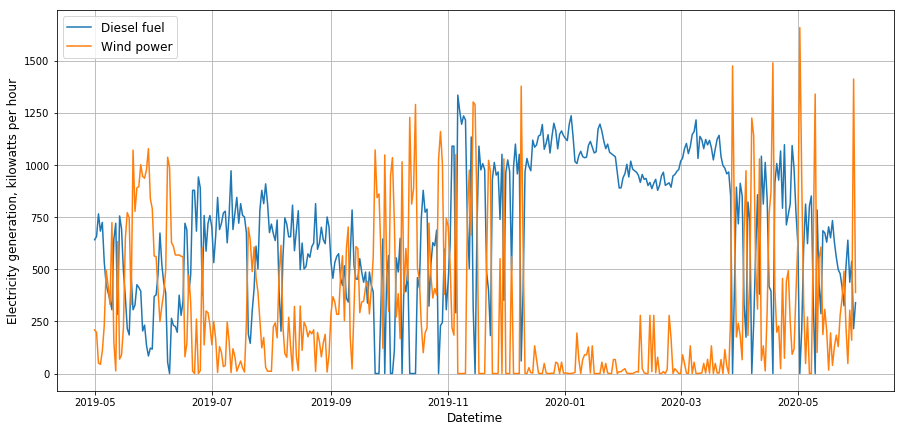

In [22]:
# Make visualisation
plot_diesel_and_wind(df)

In [23]:
# Wrap time series data into InputData class
ts = np.array(df['diesel_fuel_kWh'])
# Get data for time series implementation
train_input, validation_input = prepare_unimodal_for_validation(ts, forecast_length,
                                                                validation_blocks)

In [31]:
# Prepare parameters for algorithm launch
# timeout 2 - means that AutoML algorithm will work for 2 minutes
composer_params = {'max_depth': 4,
                   'max_arity': 3,
                   'pop_size': 20,
                   'num_of_generations': 100,
                   'timeout': 1,
                   'preset': 'light_tun',
                   'metric': 'rmse',
                   'cv_folds': 2,
                   'validation_blocks': 2}
forecast, obtained_pipeline = automl_fit_forecast(train_input, validation_input, composer_params,
                                                  vis=False, in_sample_forecasting=True,
                                                  horizon=forecast_length*validation_blocks)

Composition started. Parameters tuning: True. Set of candidate models: ['adareg', 'ar', 'catboostreg', 'dtreg', 'gbr', 'lasso', 'lgbmreg', 'linear', 'rfr', 'ridge', 'sgdr', 'stl_arima', 'svr', 'treg', 'xgbreg', 'scaling', 'normalization', 'pca', 'poly_features', 'ransac_lin_reg', 'ransac_non_lin_reg', 'rfe_lin_reg', 'rfe_non_lin_reg', 'lagged', 'sparse_lagged', 'smoothing', 'gaussian_filter']. Composing time limit: 1 min
Pipeline composition started
Fit pipeline from scratch
Fit pipeline from scratch
Fit pipeline from scratch
Fit pipeline from scratch
Fit pipeline from scratch
Fit pipeline from scratch
Fit pipeline from scratch
Fit pipeline from scratch
Fit pipeline from scratch
Fit pipeline from scratch
Fit pipeline from scratch
Fit pipeline from scratch
Fit pipeline from scratch
Fit pipeline from scratch
Fit pipeline from scratch
Fit pipeline from scratch
Fit pipeline from scratch
Fit pipeline from scratch
Fit pipeline from scratch
Fit pipeline from scratch
Fit pipeline from scratch


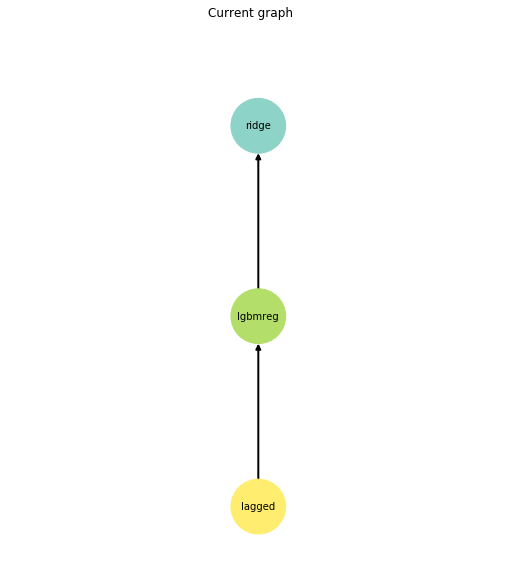

In [32]:
obtained_pipeline.show()

MAE - 270.96
RMSE - 350.23


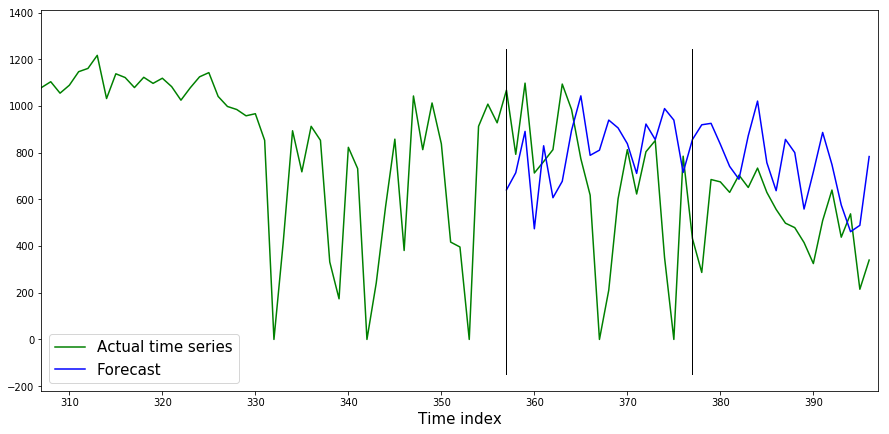

In [33]:
# Perform in-sample validation and display metrics
advanced_validation(forecast, forecast_length, validation_blocks, ts)

Если требуется экспртировать полученный пайплайн, то можно воспользоваться следующим методом

In [ ]:
# Save obtained pipeline
obtained_pipeline.save('')

В данном случае пайплайн был сохранён в файл "August-14-2021,01-11-03,AM"

Загрузить пайплайн можно при помощи следующих строк кода:

In [18]:
from fedot.core.pipelines.pipeline import Pipeline

load_pipeline = Pipeline()
load_pipeline.load('August-14-2021,01-11-03,AM\.json')

The pipeline was imported from the path: August-14-2021,01-11-03,AM\.json.


Теперь обученный пайплайн можно использовать 